In [1]:
import pickle
import collections
from urllib.request import urlopen
from data_processing import *
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
#%matplotlib inline

# Set the task and experiment type
task_name = 'swda'
base_url = 'https://raw.github.com/NathanDuran/Switchboard-Corpus/master/swda_data/'
metadata = pickle.load(urlopen(base_url + 'metadata/metadata.pkl'))
text_data = [line.decode('utf-8').rstrip('\r\n') for line in urlopen(base_url + 'train_set.txt')]

# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing. Increments of 500 in the range [500, 8000].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [2]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc']])
print("Best test accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'f1_micro']])
vocab_data_max = get_max(vocab_mean_data, [exp_param])
vocab_data_max

Best validation accuracy in mean data:
    model_name  vocab_size   val_acc
122   text cnn        5500  0.756117
Best test accuracy in mean data:
   model_name  vocab_size  test_acc  f1_micro
84       lstm        2500  0.729049  0.730449


,model_name,vocab_size,val_acc,vocab_size,test_acc,f1_micro
0,bi gru,4000,0.731305,8000,0.718470,0.720103
1,bi lstm,8000,0.749769,8000,0.728060,0.729566
2,cnn,2500,0.744975,7500,0.718491,0.719735
3,dcnn,7500,0.751531,8000,0.726971,0.728389
4,gru,8000,0.738904,6500,0.719435,0.720961
5,lstm,7000,0.752472,2500,0.729049,0.730449
6,rcnn,7500,0.743606,7000,0.717692,0.719294
7,text cnn,5500,0.756117,2500,0.728534,0.729958


Plot accuracy of each model per vocabulary size.

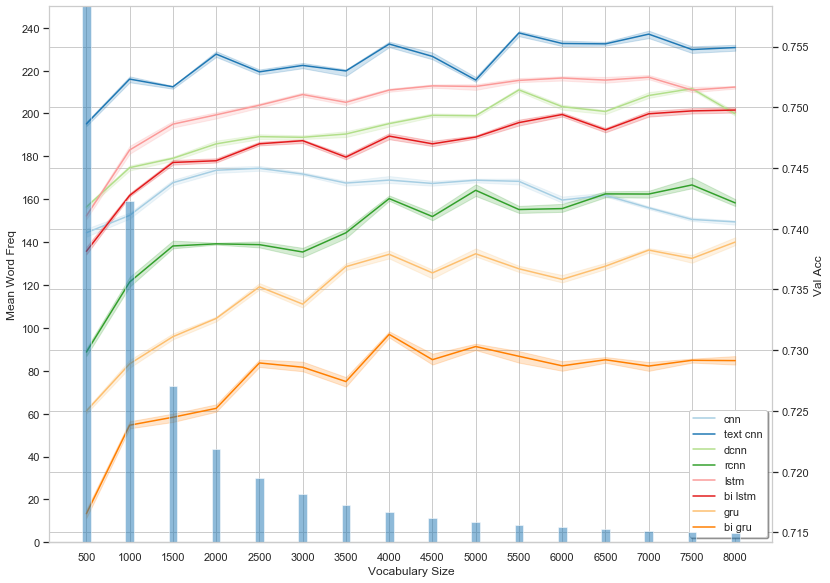

In [3]:
# TODO remove test data
# Get test and validation accuracy for each model
# vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
# vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
# vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# g, fig = plot_relplot(vocab_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci='sd',
#                       title='', y_label='Accuracy', x_label='Vocabulary Size',  share_x=False, share_y=False, num_col=1,
#                       legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

# Get word frequencies from metadata and bin into same values as experiment
word_freq = metadata['word_freq'].iloc[:8000]
ind_start = 0
ind_end = 500
freq_dict = dict()
for i in range(16):
    freq_dict[ind_end] = word_freq.loc[ind_start:ind_end].mean()
    ind_start += 500
    ind_end += 500
word_freq = pd.DataFrame.from_dict(freq_dict, orient='index')
word_freq.reset_index(level=0, inplace=True)
word_freq.rename(columns={'index': 'vocab_size'}, inplace=True)

# Get experiment validation accuracy data for each model
vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc'})
vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(vocab_acc_data, word_freq, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Val Acc', x_label='Vocabulary Size', colour='Paired',
                          bar_x=exp_param, bar_y='Count', bar_axis_step=20, bar_axis_range=[0, 250], bar_width=100,
                          bar_y_label='Mean Word Freq', bar_alpha=0.5, bar_color='tab:blue', legend_loc='best', num_legend_col=1)

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

In [4]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks for all models and vocabulary sizes
shapiro_wilk_test(vocab_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(vocab_data, exp_param, metric)

The following vocab_size are not normally distributed.
   model_name vocab_size    t-stat   p-value
11        cnn       6000  0.795897  0.012926
23   text cnn       4000  0.825526  0.029553
50       rcnn       1500  0.838140  0.041916
62       rcnn       7500  0.753436  0.003930
76       lstm       6500  0.815659  0.022455
87    bi lstm       4000  0.814240  0.021584
All models vocab_size have equal variance.


,model_name,t-stat,p-value
0,cnn,1.413760,0.148137
1,text cnn,0.758740,0.720799
2,dcnn,0.549283,0.908151
3,rcnn,0.893647,0.572526
4,lstm,0.960897,0.499452
5,bi lstm,0.936507,0.525635
6,gru,0.577683,0.888292
7,bi gru,1.005563,0.452810


Perform ANOVA for each model, comparing different vocabulary size groups,
followed by Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

In [5]:
# Run ANOVA
one_way_anova_test(vocab_data, exp_param, metric)

All models have significant p-values when comparing vocab_size groups.


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,0.000416,15.0,0.000028,5.326351,2.025392e-08,0.356842,0.288558
text cnn,0.000564,15.0,0.000038,6.178238,6.645045e-10,0.391567,0.326808
dcnn,0.000982,15.0,0.000065,15.746608,1.838878e-23,0.621251,0.580272
rcnn,0.001876,15.0,0.000125,10.350516,1.795819e-16,0.518809,0.467124
lstm,0.001293,15.0,0.000086,17.218715,3.891193e-25,0.642041,0.603254
bi lstm,0.001336,15.0,0.000089,18.407561,1.987861e-26,0.657235,0.620055
gru,0.002217,15.0,0.000148,14.953782,1.597458e-22,0.609022,0.566756
bi gru,0.001918,15.0,0.000128,10.018167,5.446340e-16,0.510658,0.458128


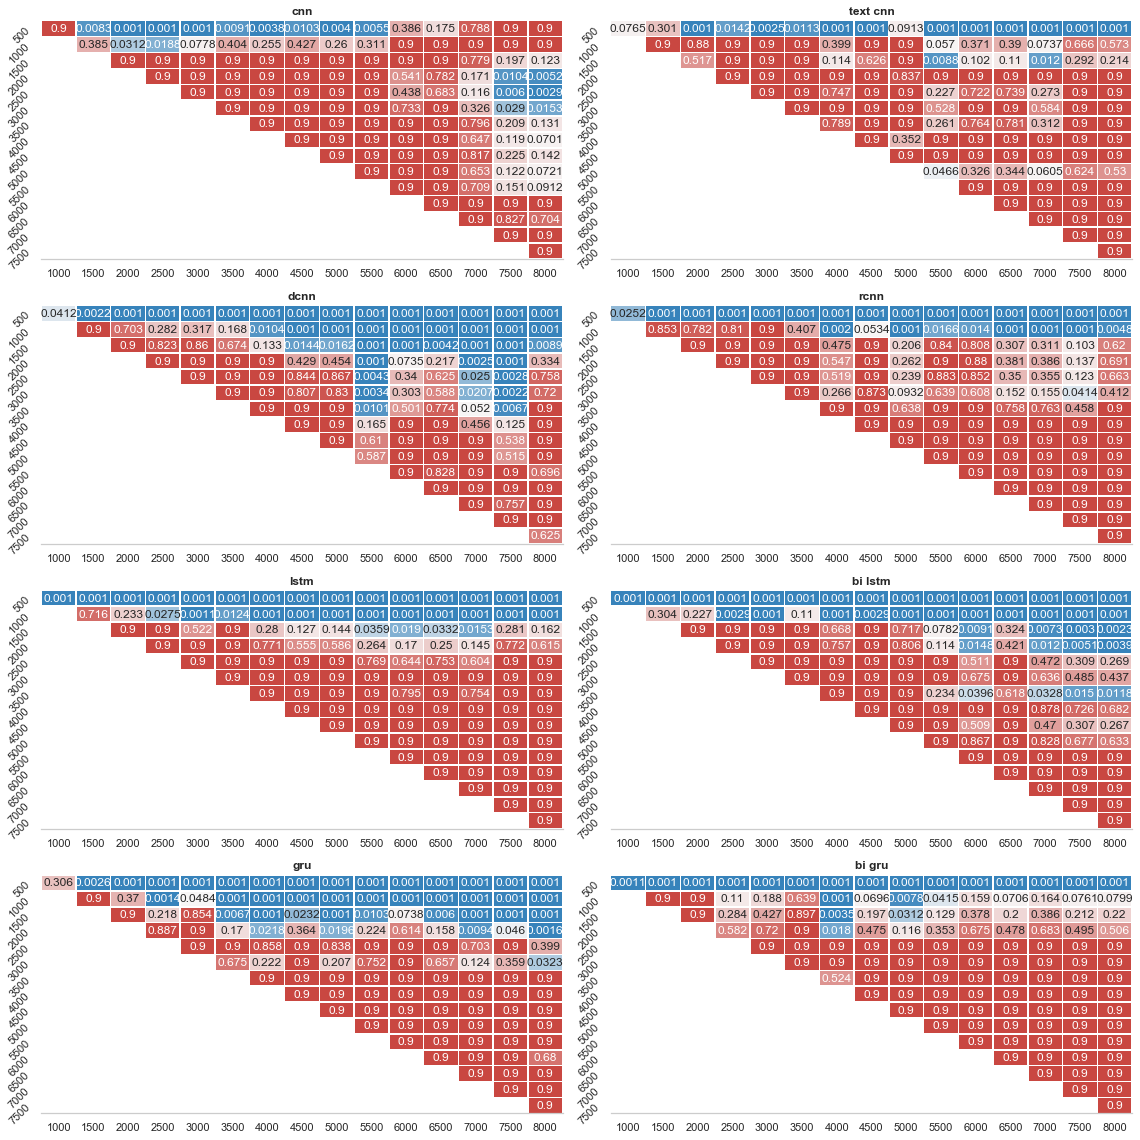

In [6]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric, show_result=False)

# Remove vocab_size > 5000 to make plots nicer
# tukey_frame.drop(tukey_frame[(tukey_frame.group1 > 5000) | (tukey_frame.group2 > 5000)].index, inplace=True)
# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Sequence Length
The number of tokens in the input sequence. Sentences are padded or truncated to this length.
Increments of 5 in the range [5, 50].

Get the sequence length corresponding to max validation and test accuracy per model.

In [7]:
# Name of the experiment parameter for comparison
exp_param = 'max_seq_length'

# Load sequence length experiment data
seq_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
seq_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc']])
print("Best test accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'f1_micro']])
seq_data_max = get_max(seq_mean_data, [exp_param])
seq_data_max

Best validation accuracy in mean data:
   model_name  max_seq_length  val_acc
74   text cnn              25  0.75633
Best test accuracy in mean data:
   model_name  max_seq_length  test_acc  f1_micro
59       lstm              50  0.729147  0.730547


,model_name,max_seq_length,val_acc,max_seq_length,test_acc,f1_micro
0,bi gru,30,0.735057,50,0.720430,0.722015
1,bi lstm,35,0.748553,50,0.723076,0.724589
2,cnn,45,0.744300,35,0.717816,0.719196
3,dcnn,30,0.751016,35,0.726751,0.728169
4,gru,25,0.739449,40,0.721055,0.722726
5,lstm,25,0.753496,50,0.729147,0.730547
6,rcnn,40,0.744993,50,0.721986,0.723633
7,text cnn,25,0.756330,20,0.728208,0.729493


Plot accuracy of each model per sequence length.

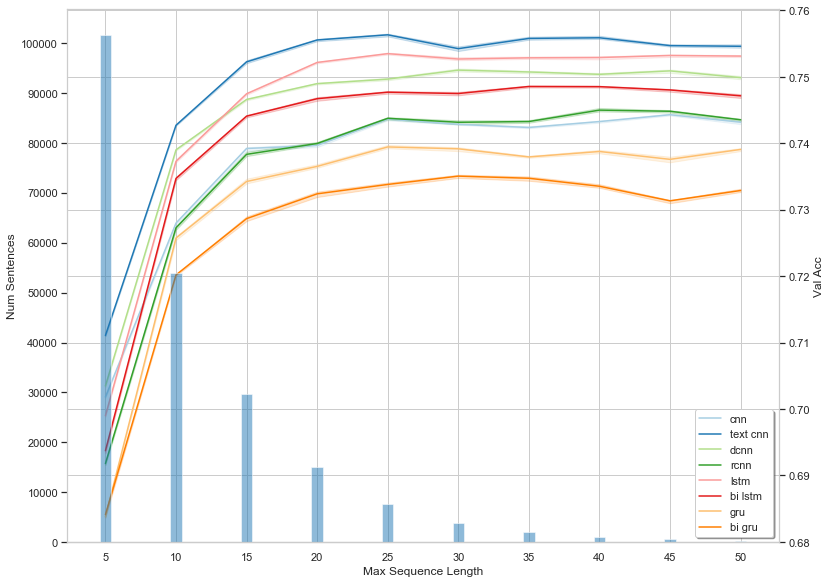

In [8]:
# TODO remove test data
# Get test and validation accuracy for each model
# seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
# seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
# seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])
#
# g, fig = plot_relplot(seq_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci='sd',
#                       title='', y_label='Accuracy', x_label='Sequence Length',  share_x=False, share_y=False, num_col=1,
#                       legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

# Get text data from training set and count sequence lengths
sentences = [line.split('|')[1] for line in text_data]
sent_lengths = [len(sent.split(' ')) for sent in sentences]
sent_lengths = collections.Counter(sent_lengths)
sent_lengths = pd.DataFrame.from_dict(dict(sorted(sent_lengths.items())), orient='index')

# Bin into same values as experiment
ind_start = 0
ind_end = 5
freq_dict = dict()
for i in range(10):
    freq_dict[ind_end] = sent_lengths.loc[ind_start:ind_end].sum()
    ind_start += 5
    ind_end += 5
sent_lengths = pd.DataFrame.from_dict(freq_dict, orient='index')
sent_lengths.reset_index(level=0, inplace=True)
sent_lengths.rename(columns={'index': 'max_seq_length', 0: 'Count'}, inplace=True)

# Get experiment validation accuracy data for each model
seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc'})
seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(seq_acc_data, sent_lengths, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Val Acc', x_label='Max Sequence Length', colour='Paired',
                          bar_x=exp_param, bar_y='Count', bar_axis_step=10000, bar_axis_range=None, bar_width=0.8,
                          bar_y_label='Num Sentences', bar_alpha=0.5, bar_color='tab:blue', legend_loc='lower right', num_legend_col=1)

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

In [9]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks for all models and sequence lengths
shapiro_wilk_test(seq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(seq_data, exp_param, metric)

The following max_seq_length are not normally distributed.
   model_name max_seq_length    t-stat   p-value
4         cnn             25  0.779165  0.008087
17   text cnn             40  0.817418  0.023583
61        gru             10  0.819748  0.025165
78     bi gru             45  0.700521  0.000894
All models max_seq_length have equal variance.


,model_name,t-stat,p-value
0,cnn,1.431609,0.186555
1,text cnn,1.864271,0.067530
2,dcnn,0.679021,0.725923
3,rcnn,1.326725,0.234409
4,lstm,1.140888,0.342903
5,bi lstm,1.435222,0.185065
6,gru,0.563222,0.823687
7,bi gru,0.808153,0.609863


Perform ANOVA for each model, comparing different sequence length groups,
followed by Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

In [10]:
# Run ANOVA
one_way_anova_test(seq_data, exp_param, metric)

All models have significant p-values when comparing max_seq_length groups.


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,0.015699,9.0,0.001744,364.465080,8.926812e-67,0.973295,0.970337
text cnn,0.017700,9.0,0.001967,372.079519,3.614924e-67,0.973827,0.970928
dcnn,0.019494,9.0,0.002166,480.181912,4.985668e-72,0.979599,0.977338
rcnn,0.024330,9.0,0.002703,374.900643,2.597900e-67,0.974019,0.971141
lstm,0.026222,9.0,0.002914,760.126463,7.580867e-81,0.987015,0.985574
bi lstm,0.026052,9.0,0.002895,428.025018,7.810157e-70,0.977170,0.974640
gru,0.026561,9.0,0.002951,323.453113,1.631616e-64,0.970011,0.966690
bi gru,0.021862,9.0,0.002429,239.557288,7.261034e-59,0.959929,0.955497


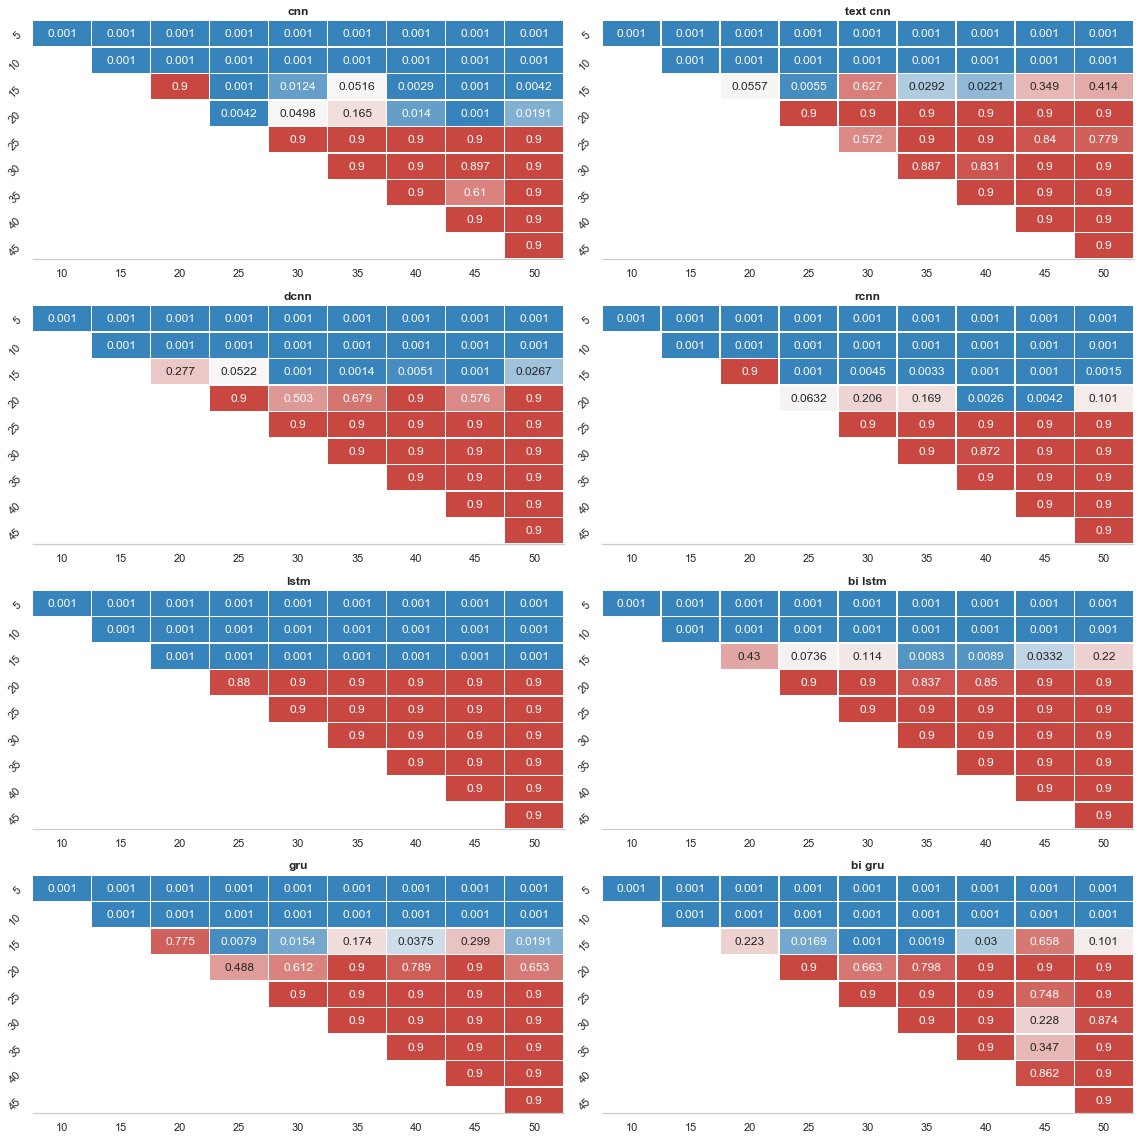

In [11]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(seq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Use Punctuation
Whether to remove punctuation from the input sentences or not.

Show punctuation flag value corresponding to max validation and test accuracy per model.

In [12]:
# Name of the experiment parameter for comparison
exp_param = 'use_punct'

# Load punctuation experiment data
punc_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
punc_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(punc_mean_data.loc[[punc_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc']])
print("Best test accuracy in mean data:")
print(punc_mean_data.loc[[punc_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'f1_micro']])
punc_data_max = get_max(punc_mean_data, [exp_param])
punc_data_max

Best validation accuracy in mean data:
   model_name  use_punct  val_acc
15   text cnn       True  0.75611
Best test accuracy in mean data:
  model_name  use_punct  test_acc  f1_micro
7       dcnn       True   0.72798  0.729542


,model_name,use_punct,val_acc,use_punct,test_acc,f1_micro
0,bi gru,True,0.729192,True,0.715492,0.717112
1,bi lstm,True,0.748794,True,0.722832,0.724344
2,cnn,True,0.744598,True,0.715265,0.716524
3,dcnn,True,0.750176,True,0.727980,0.729542
4,gru,True,0.736974,True,0.714360,0.715837
5,lstm,True,0.752520,True,0.723397,0.724884
6,rcnn,True,0.740616,True,0.719982,0.721500
7,text cnn,True,0.756110,True,0.727905,0.729272


Plot accuracy of each model per punctuation flag value.

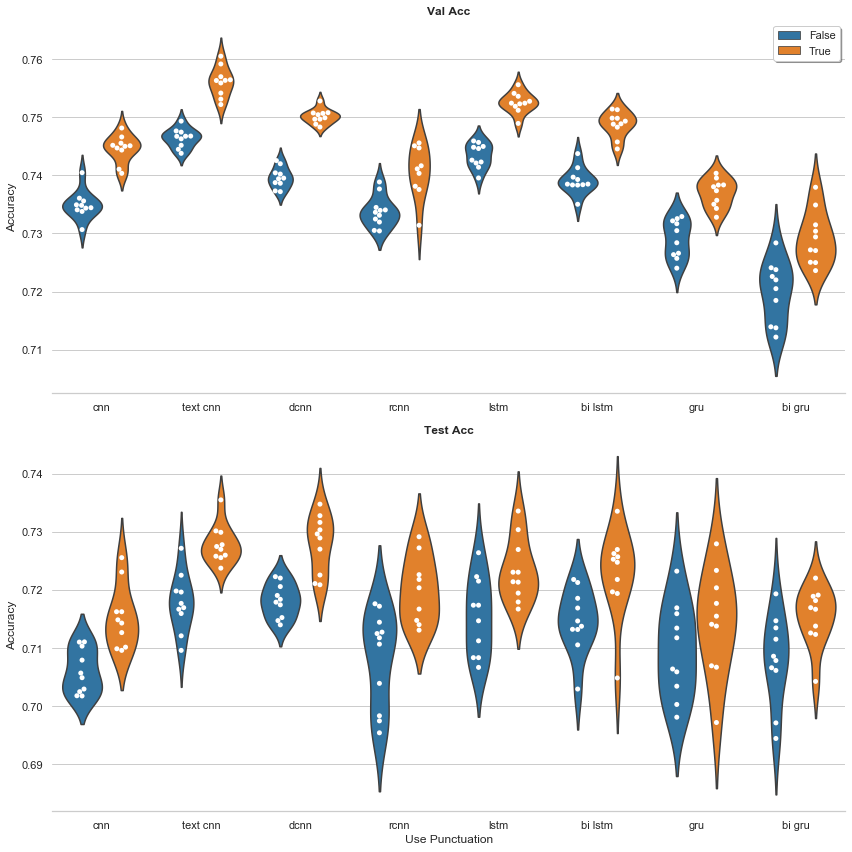

In [13]:
# TODO remove test data
# Get test and validation accuracy for each model
punc_acc_data = punc_data.drop(punc_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
punc_acc_data = punc_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
punc_acc_data = punc_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(punc_acc_data, x="model_name", y="value", hue=exp_param, col='variable', kind='swarm_violin',
                            num_legend_col=1, y_label='Accuracy', x_label='Use Punctuation',
                            share_y=False, num_col=1, dodge=True, colour='default')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

In [14]:
# Set the metric to test and statistical significance level
metric = 'val_acc'

# Run Shaprio-wilks for all models and punctuation flag value
shapiro_wilk_test(punc_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(punc_data, exp_param, metric)

All models use_punct are normally distributed.
All models use_punct have equal variance.


,model_name,t-stat,p-value
0,cnn,0.003713,0.952082
1,text cnn,0.933978,0.346638
2,dcnn,1.061295,0.316565
3,rcnn,1.836328,0.192145
4,lstm,1.592342,0.223099
5,bi lstm,0.038891,0.845874
6,gru,2.199544,0.155350
7,bi gru,0.187997,0.669741


Perform t-test comparing punctuation true and false for each model.

In [15]:
# Run t-test
t_test(punc_data, exp_param, metric)

All models have significant p-values when comparing use_punct groups.


,model_name,t-stat,p-value
0,cnn,-9.093682,3.774000e-08
1,text cnn,-10.175668,6.826824e-09
2,dcnn,-15.490012,7.518729e-12
3,rcnn,-4.263384,4.675678e-04
4,lstm,-10.489057,4.262169e-09
5,bi lstm,-9.742328,1.332627e-08
6,gru,-6.132616,8.599319e-06
7,bi gru,-4.163449,5.837580e-04


# Input Sequence Combinations

Compare minimum and maximum vocabulary size (5k or 10k words), sequence lengths (50 or 128 tokens) and use of punctuation.

Combination | Punc True | Punc False
----------- | :-------: | :--------:
Seq=50 Voc=5k   | [x]       | [x]
Seq=128 Voc=5k  | [x]       | [x]
Seq=50 Voc=10k  | [x]       | [x]
Seq=128 Voc=10k | [x]       | [x]

In [16]:
# Name of the experiment parameters for comparison
exp_params = ['vocab_size', 'max_seq_length', 'use_punct']
# Load punctuation experiment data
inseq_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_data.csv'))
inseq_mean_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc']])
print("Best test accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'f1_micro']])
inseq_data_max = get_max(inseq_mean_data, exp_params)
inseq_data_max

Best validation accuracy in mean data:
   model_name  vocab_size  max_seq_length  use_punct   val_acc
29       lstm       10000              50       True  0.753843
Best test accuracy in mean data:
   model_name  vocab_size  max_seq_length  use_punct  test_acc  f1_micro
31       lstm       10000             128       True  0.729017  0.730277


,model_name,vocab_size,max_seq_length,use_punct,val_acc,vocab_size,max_seq_length,use_punct,test_acc,f1_micro
0,cnn,5000,128,True,0.748775,5000,128,True,0.719028,0.720275
1,dcnn,10000,50,True,0.747283,10000,50,True,0.724346,0.725864
2,gru,5000,50,True,0.743705,10000,128,True,0.718773,0.720324
3,lstm,10000,50,True,0.753843,10000,128,True,0.729017,0.730277
4,rcnn,10000,50,True,0.745803,10000,128,True,0.718962,0.720569
5,text cnn,10000,128,True,0.753271,10000,128,True,0.726274,0.727801


Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

In [17]:
# Add column to identify each combination
# inseq_data = inseq_data.drop(inseq_data.columns.difference(['model_name', 'val_acc', 'use_punct', 'vocab_size', 'max_seq_length']), axis=1)
# conditions = [(inseq_data['use_punct'] == True) &(inseq_data['vocab_size'] == 5000) & (inseq_data['max_seq_length'] == 50),
#               (inseq_data['use_punct'] == True) &(inseq_data['vocab_size'] == 5000) & (inseq_data['max_seq_length'] == 128),
#               (inseq_data['use_punct'] == True) &(inseq_data['vocab_size'] == 10000) & (inseq_data['max_seq_length'] == 50),
#               (inseq_data['use_punct'] == True) &(inseq_data['vocab_size'] == 10000) & (inseq_data['max_seq_length'] == 128),
#               (inseq_data['use_punct'] == False) &(inseq_data['vocab_size'] == 5000) & (inseq_data['max_seq_length'] == 50),
#               (inseq_data['use_punct'] == False) &(inseq_data['vocab_size'] == 5000) & (inseq_data['max_seq_length'] == 128),
#               (inseq_data['use_punct'] == False) &(inseq_data['vocab_size'] == 10000) & (inseq_data['max_seq_length'] == 50),
#               (inseq_data['use_punct'] == False) &(inseq_data['vocab_size'] == 10000) & (inseq_data['max_seq_length'] == 128),]
# choices = ['P=t_V=5k_S=50', 'P=t_V=5k_S=128', 'P=t_V=10k_S=50', 'P=t_V=10k_S=128',
#            'P=f_V=5k_S=50', 'P=f_V=5k_S=128', 'P=f_V=10k_S=50', 'P=f_V=10k_S=128']
# inseq_data['exp_params'] = np.select(conditions, choices)

inseq_data = inseq_data.drop(inseq_data.columns.difference(['model_name', 'val_acc', 'use_punct', 'vocab_size', 'max_seq_length']), axis=1)
conditions = [(inseq_data['use_punct'] == True) &(inseq_data['vocab_size'] == 5000) & (inseq_data['max_seq_length'] == 50),
              (inseq_data['use_punct'] == True) &(inseq_data['vocab_size'] == 5000) & (inseq_data['max_seq_length'] == 128),
              (inseq_data['use_punct'] == True) &(inseq_data['vocab_size'] == 10000) & (inseq_data['max_seq_length'] == 50),
              (inseq_data['use_punct'] == True) &(inseq_data['vocab_size'] == 10000) & (inseq_data['max_seq_length'] == 128),]
choices = ['V=5k_S=50', 'V=5k_S=128', 'V=10k_S=50', 'V=10k_S=128']
inseq_data['exp_params'] = np.select(conditions, choices)
inseq_data.drop(inseq_data[inseq_data.exp_params == '0'].index, inplace=True)
print(inseq_data)
# Set the metric to test and new exp_param column
metric = 'val_acc'
exp_param = 'exp_params'

# Run Shaprio-wilks for all models and punctuation flag value
shapiro_wilk_test(inseq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(inseq_data, exp_param, metric)

    model_name  vocab_size  max_seq_length  use_punct   val_acc   exp_params
0          cnn        5000              50       True  0.749960    V=5k_S=50
1          cnn       10000              50       True  0.747444   V=10k_S=50
2          cnn       10000              50       True  0.742513   V=10k_S=50
12         cnn       10000              50       True  0.747108   V=10k_S=50
14         cnn        5000             128       True  0.746908   V=5k_S=128
..         ...         ...             ...        ...       ...          ...
474        gru       10000             128       True  0.740840  V=10k_S=128
475        gru       10000             128       True  0.747486  V=10k_S=128
476        gru       10000             128       True  0.743106  V=10k_S=128
477        gru       10000             128       True  0.743972  V=10k_S=128
478        gru       10000             128       True  0.742340  V=10k_S=128

[240 rows x 6 columns]
All models exp_params are normally distributed.
The 

,model_name,t-stat,p-value
0,cnn,0.905085,0.448195
1,text cnn,1.760117,0.172229
2,dcnn,0.196995,0.897754
3,rcnn,0.383324,0.765624
4,lstm,0.601746,0.618091
5,gru,3.321013,0.030460


Perform ANOVA for each model, comparing different sequence length and vocabulary size groups,
followed by Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

In [18]:
# Run ANOVA
one_way_anova_test(inseq_data, exp_param, metric)

The following models do not have significant p-values when comparing exp_params groups.
            sum_sq   df   mean_sq         F    PR(>F)    eta_sq  omega_sq
cnn       0.000038  3.0  0.000013  2.268195  0.097171  0.158969  0.086854
text cnn  0.000005  3.0  0.000002  0.352566  0.787527  0.028542 -0.051036
dcnn      0.000021  3.0  0.000007  1.182710  0.329945  0.089717  0.013518
rcnn      0.000046  3.0  0.000015  2.779130  0.055037  0.188044  0.117726
lstm      0.000010  3.0  0.000003  1.056659  0.379527  0.080929  0.004231
gru       0.000016  3.0  0.000005  0.822207  0.490225  0.064124 -0.013515


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,0.000038,3.0,0.000013,2.268195,0.097171,0.158969,0.086854
text cnn,0.000005,3.0,0.000002,0.352566,0.787527,0.028542,-0.051036
dcnn,0.000021,3.0,0.000007,1.182710,0.329945,0.089717,0.013518
rcnn,0.000046,3.0,0.000015,2.779130,0.055037,0.188044,0.117726
lstm,0.000010,3.0,0.000003,1.056659,0.379527,0.080929,0.004231
gru,0.000016,3.0,0.000005,0.822207,0.490225,0.064124,-0.013515


In [19]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(inseq_data, exp_param, metric, show_result=True)
# print(tukey_frame)
# Generate heatmaps
# g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
#                         title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
#                         annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
#                         y_tick_rotation=0, x_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

The following models do not have significant p-values when comparing exp_params groups.
   model_name       group1      group2  meandiff  p-value   lower   upper  reject
0         cnn  V=10k_S=128  V=10k_S=50   -0.0006   0.9000 -0.0035  0.0022   False
2         cnn  V=10k_S=128   V=5k_S=50    0.0015   0.5081 -0.0014  0.0043   False
5         cnn   V=5k_S=128   V=5k_S=50   -0.0002   0.9000 -0.0030  0.0026   False
6    text cnn  V=10k_S=128  V=10k_S=50   -0.0009   0.7672 -0.0035  0.0017   False
7    text cnn  V=10k_S=128  V=5k_S=128   -0.0007   0.8597 -0.0033  0.0019   False
8    text cnn  V=10k_S=128   V=5k_S=50   -0.0003   0.9000 -0.0029  0.0023   False
9    text cnn   V=10k_S=50  V=5k_S=128    0.0002   0.9000 -0.0024  0.0028   False
10   text cnn   V=10k_S=50   V=5k_S=50    0.0006   0.9000 -0.0020  0.0032   False
11   text cnn   V=5k_S=128   V=5k_S=50    0.0004   0.9000 -0.0022  0.0030   False
12       dcnn  V=10k_S=128  V=10k_S=50    0.0011   0.7293 -0.0019  0.0040   False
13       d

# TODO Word Vectors

Compare different dimensions of Word2Vec, GloVe, Fasttext, Numberbatch, Dependency and Random for each model.
Dimension increments of 50 in range [100, 300].

In [20]:
# Name of the experiment parameter for comparison
exp_params = ['embedding_type', 'embedding_dim']

# Load language models experiment data
embed_data = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_data.csv'))
embed_mean_data = load_dataframe(os.path.join(task_name,  'embedding_type', 'embedding_type_mean_data.csv'))


# Get the max values for each model
print("Best validation accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc']])
print("Best test accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'f1_micro']])
embed_data_max = get_max(embed_mean_data, exp_params)
embed_data_max

Best validation accuracy in mean data:
    model_name embedding_type  embedding_dim   val_acc
169   text cnn    numberbatch            300  0.760104
Best test accuracy in mean data:
    model_name embedding_type  embedding_dim  test_acc  f1_micro
169   text cnn    numberbatch            300  0.736631   0.73795


,model_name,embedding_type,embedding_dim,val_acc,embedding_type,embedding_dim,test_acc,f1_micro
0,cnn,numberbatch,100,0.745930,numberbatch,100,0.717383,0.718706
1,dcnn,fasttext,200,0.756579,glove,100,0.729668,0.730792
2,gru,fasttext,100,0.748738,fasttext,100,0.725309,0.726943
3,lstm,glove,300,0.755653,glove,300,0.731138,0.732434
4,rcnn,fasttext,200,0.750575,fasttext,250,0.727044,0.728463
5,text cnn,numberbatch,300,0.760104,numberbatch,300,0.736631,0.737950


Plot accuracy of each model per embedding type and dimension.

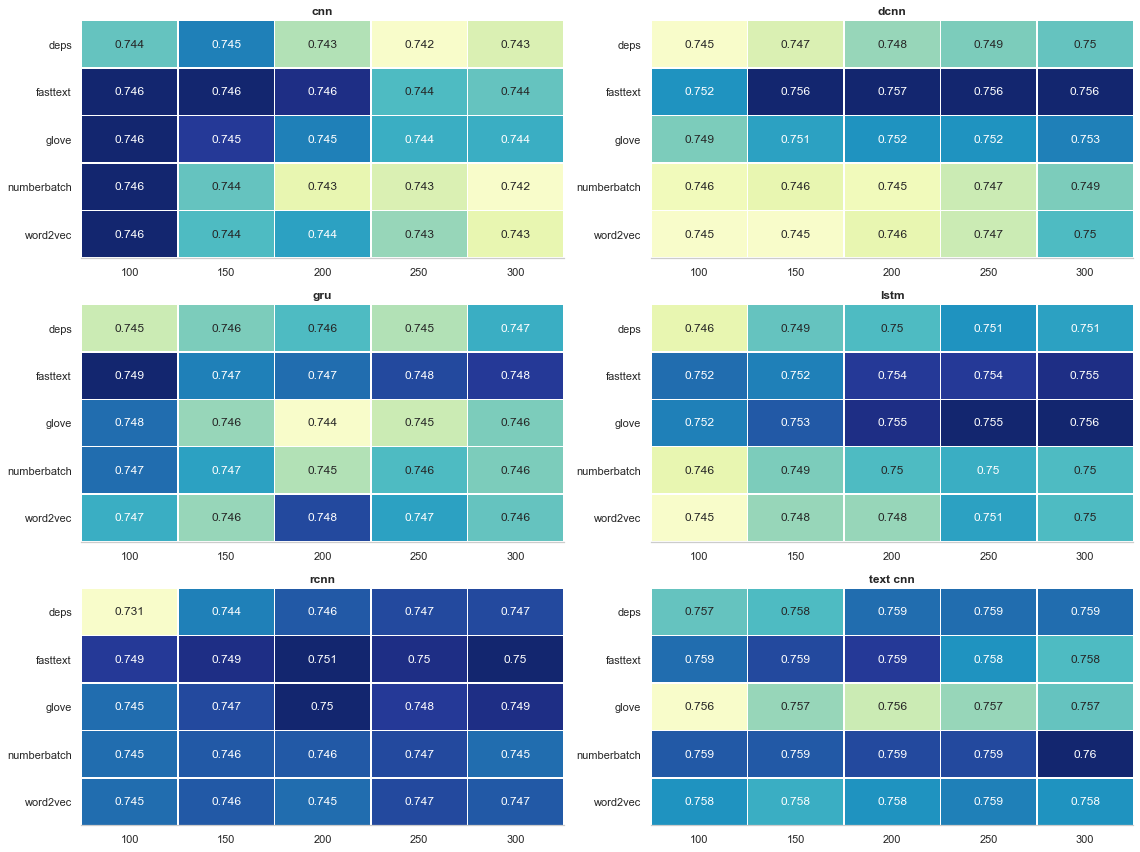

In [33]:
# Get test and validation accuracy for each model
embed_acc_data = embed_mean_data.drop(embed_mean_data.columns.difference(['model_name'] + exp_params + ['val_acc', 'test_acc']), axis=1)
# Remove random embeddings
embed_acc_data = embed_acc_data.drop(embed_acc_data[embed_acc_data['embedding_type'] == 'random'].index)

g, fig = plot_facetgrid(embed_acc_data, x='embedding_type', y='embedding_dim', hue='val_acc', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='YlGnBu', num_colour=20,
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

In [22]:
# Set the metric to test
metric = 'val_acc'

for embed_type in embed_data['embedding_type'].unique():
    data = embed_data.loc[embed_data['embedding_type'] == embed_type]
    print("Embedding Type: " + embed_type)
    # Run Shaprio-wilks for all models and sequence lengths
    shapiro_wilk_test(data, 'embedding_type', metric)

    # Run Levene test for equal variance
    levene_test(data, 'embedding_dim', metric)

Embedding Type: glove
The following embedding_type are not normally distributed.
  model_name embedding_type    t-stat   p-value
3       rcnn          glove  0.904344  0.000671
All models embedding_dim have equal variance.
Embedding Type: fasttext
All models embedding_type are normally distributed.
The following models embedding_dim do not have equal variance.
  model_name    t-stat   p-value
0        cnn  3.886063  0.008544
Embedding Type: numberbatch
The following embedding_type are not normally distributed.
  model_name embedding_type    t-stat   p-value
3       rcnn    numberbatch  0.846879  0.000013
All models embedding_dim have equal variance.
Embedding Type: random
The following embedding_type are not normally distributed.
  model_name embedding_type    t-stat       p-value
1   text cnn         random  0.741367  4.958818e-08
3       rcnn         random  0.936402  9.732377e-03
5        gru         random  0.951934  4.098602e-02
All models embedding_dim have equal variance.
Embedd

Perform Two-way ANOVA for each model, comparing different embedding type and dimension groups,
followed by Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

In [23]:
# Run Two-way ANOVA
two_way_anova_test(embed_data, 'embedding_dim', 'embedding_type', metric, show_result=True)

The following models do not have significant p-values when comparing embedding_dim and embedding_type groups.
  model_name                          exp_params    sum_sq    df   mean_sq         F    PR(>F)    eta_sq  omega_sq
3   text cnn                    C(embedding_dim)  0.036637   4.0  0.009159  1.222597  0.301483  0.010205  0.001854
5   text cnn  C(embedding_dim):C(embedding_type)  0.180285  20.0  0.009014  1.203260  0.250773  0.050218  0.008465
9       rcnn                    C(embedding_dim)  0.000402   4.0  0.000100  1.841983  0.121048  0.007525  0.003436


,model_name,exp_params,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
0,cnn,C(embedding_dim),0.000211,4.0,0.000053,13.986391,2.202048e-10,0.011448,0.010628
1,cnn,C(embedding_type),0.016927,5.0,0.003385,898.145271,6.142474e-166,0.918961,0.917750
2,cnn,C(embedding_dim):C(embedding_type),0.000264,20.0,0.000013,3.503434,1.497659e-06,0.014339,0.010244
3,text cnn,C(embedding_dim),0.036637,4.0,0.009159,1.222597,3.014834e-01,0.010205,0.001854
4,text cnn,C(embedding_type),1.350417,5.0,0.270083,36.051779,3.201623e-28,0.376155,0.364960
5,text cnn,C(embedding_dim):C(embedding_type),0.180285,20.0,0.009014,1.203260,2.507731e-01,0.050218,0.008465
6,dcnn,C(embedding_dim),0.000665,4.0,0.000166,36.107868,3.627994e-24,0.087580,0.085103
7,dcnn,C(embedding_type),0.005447,5.0,0.001089,236.764012,1.738965e-96,0.717844,0.714379
8,dcnn,C(embedding_dim):C(embedding_type),0.000234,20.0,0.000012,2.544079,4.069899e-04,0.030854,0.018715
9,rcnn,C(embedding_dim),0.000402,4.0,0.000100,1.841983,1.210483e-01,0.007525,0.003436


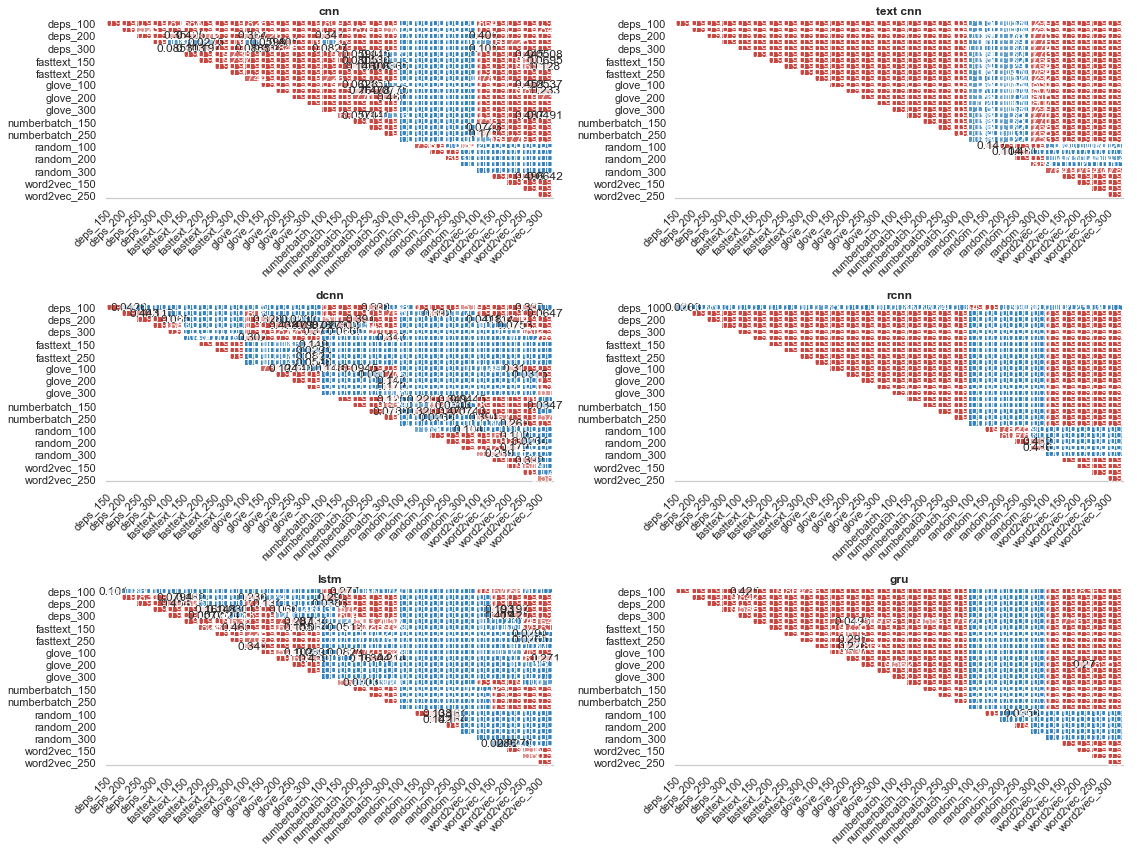

In [24]:
# Add embedding type and dimension column
embed_data['embedding'] = embed_data.apply(lambda row: row['embedding_type'] + "_" + str(row['embedding_dim']), axis=1)

# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(embed_data, 'embedding', metric, show_result=False)

# Generate heatmap
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=0, x_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# TODO Attentional / multi-layer models

# Language Models

Using pre-trained language models to generate sequence representations.

In [25]:
# Name of the experiment parameter for comparison
exp_param = 'embedding_type'

# Load language models experiment data
lm_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_data.csv'))
lm_mean_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc']])
print("Best test accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'f1_micro']])
lm_data_max = get_max(lm_mean_data, [exp_param])
lm_data_max.drop('embedding_type', axis=1, inplace=True)
lm_data_max

Best validation accuracy in mean data:
  model_name   val_acc
1    roberta  0.781663
Best test accuracy in mean data:
  model_name  test_acc  f1_micro
1    roberta  0.762172   0.76227


,model_name,val_acc,test_acc,f1_micro
0,bert,0.768694,0.760679,0.762099
1,roberta,0.781663,0.762172,0.762270
2,gpt2,0.774725,0.751557,0.751557
3,dialogpt,0.778209,0.753003,0.753003
4,xlnet,0.781540,0.758838,0.758838
5,convert,0.765390,0.743066,0.744496
6,elmo,0.759993,0.731891,0.733636
7,use,0.762036,0.735063,0.736210
8,mlstm char lm,0.757773,0.734759,0.736210
9,nnlm,0.734443,0.701229,0.702206


Plot accuracy of each language model.

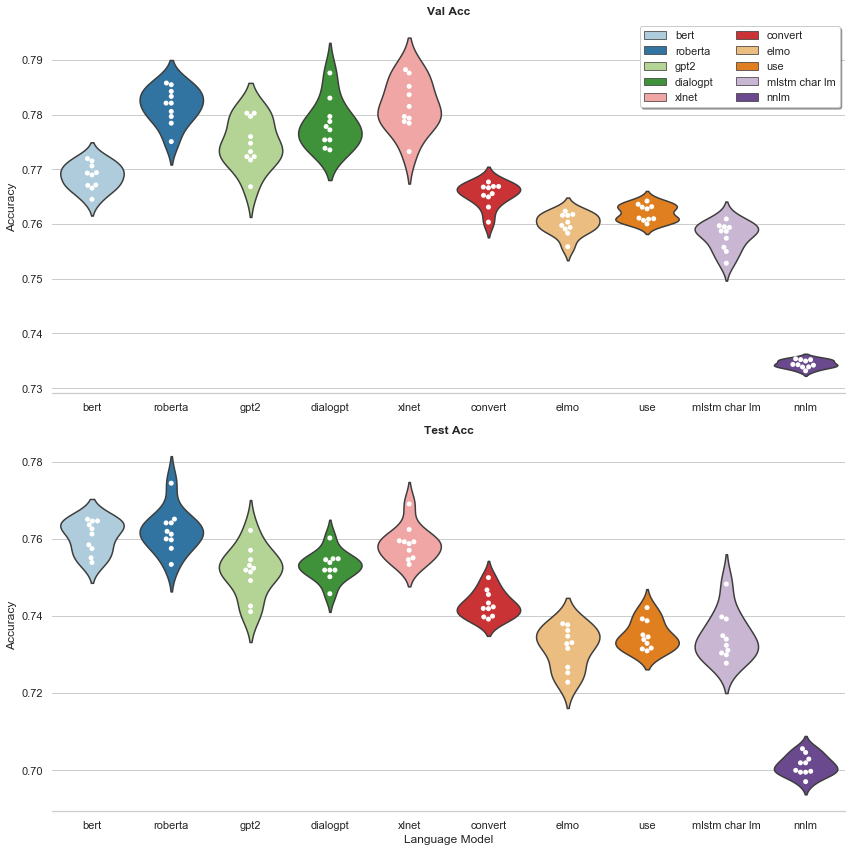

In [26]:
# TODO remove test data
# Get test and validation accuracy for each model
lm_acc_data = lm_data.drop(lm_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
lm_acc_data = lm_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
lm_acc_data = lm_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(lm_acc_data, x="model_name", y="value", hue="model_name", col='variable', kind='swarm_violin',
                        num_legend_col=2, y_label='Accuracy', x_label='Language Model',
                        share_y=False, num_col=1, colour='Paired', dodge=False)

# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))